
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 4: Logistic Regression

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- **This is an individual homework. No group collaboration.**
- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile


import seaborn as sns
sns.set()


<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `data/dataset_hw4.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with **0 indicating the ALL** class and **1 indicating the AML** class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. 


<div class='exercise'><b> Question 1 [20 pts]: Data Exploration </b></div>

First step is to  split  the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.


**1.1** Take a peek at your training set (show a glimpse of what you did): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


**1.2** The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a data set? Explain in 3 or fewer sentences.


**1.3** Identify and report which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the data set).  Note: it wil lbe useful to save this list for future parts.

Plot two histograms ofyour best predictor - one using training and another for the testing dataset. Each histogram should clearly distinguish two different `Cancer_type` classes.

Hint: You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.


**1.4** Using your top gene from the previous part (call it  `best_predictor`), create a classification model by manually eye-balling a value for this gene that would discriminate the two classes the best. Justify your choice in 1-2 sentences. Report the accuracy of this hand-chosen model on the test set.

<hr> <hr>

### Solutions

**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.**

In [3]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)


X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

In [4]:

print(df.shape)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(df.Cancer_type.value_counts(normalize=True))


(752, 7130)
(601, 7129) (151, 7129) (601,) (151,)
0.0    0.511968
1.0    0.488032
Name: Cancer_type, dtype: float64


**1.1 Take a peek at your training set (show a glimpse of what you did): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.**


In [5]:
# displaying first few columns of training set
X_train.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
486,-83.669345,-129.202197,91.188553,-132.634919,-416.659258,-566.248620,-549.255222,-208.415176,213.331881,-135.518811,...,111.849800,371.083898,252.006568,963.153393,9.955941,142.181944,442.730023,42.848269,512.106908,4.677488
604,-65.718571,-302.842019,-297.819728,-177.485917,-52.709137,-218.295750,195.983474,-268.235930,-328.630912,240.058672,...,252.867110,110.033722,203.197907,101.612259,-138.398658,245.767616,247.519122,-15.430358,-398.165984,-61.694246
341,-264.191248,-162.255274,127.997172,173.771779,-185.191211,40.011778,-1562.983106,-85.344926,-119.622143,219.619110,...,20.797496,-184.115075,-227.872398,140.876523,42.543763,28.594281,204.479474,9.831559,21.718266,19.522122
117,-92.558574,-109.788332,379.542547,391.641129,-184.507364,-577.178389,-293.421369,-372.534572,190.551199,-487.331438,...,180.678776,577.889184,-50.443125,417.586154,-11.190519,1478.997020,15.923333,112.986515,-107.706335,-25.673203
516,-143.099813,140.202023,-147.163850,222.339115,-231.007621,-753.616356,274.500343,-217.513332,-107.135509,-62.470938,...,139.821329,909.588696,43.531613,718.462679,-58.238405,232.494165,754.787059,-58.160474,1808.764690,-20.782346


In [6]:
# Normalizing data - following Section 4

# store the columns first
columns = X_train.columns.values.tolist()

# Normalize X_train
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # turns it into a numpy array
X_train = pd.DataFrame(X_train, columns = columns)   # need to turn it back into a dataframe

# Normalize X_test
X_test = scaler.transform(X_test)  # turns it into a numpy array
X_test = pd.DataFrame(X_test, columns = columns)   # need to turn it back into a dataframe

# # Normalize y_train
# # turn into nx1 matrix first
# y_train_reshaped = np.array(y_train).reshape(-1,1)
# y_train = MinMaxScaler().fit_transform(y_train_reshaped)
# y_train = pd.DataFrame(y_train, columns = ['Cancer_type']) 

# # Normalize y_test
# y_test = MinMaxScaler().fit_transform(y_train_reshaped)  # FIT ON TRAIN
# y_test = pd.DataFrame(y_test, columns = ['Cancer_type']) 

**1.2 The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a data set? Explain in 3 or fewer sentences.**

Having more predictors than observations is almost certainly leading to multicollinearity among the predictors. This would be because there wouldn't be unique solutions for every single predictor or variable meaning that some predictors could be linearly dependent on other predictors. This is a problem that we would fix with cross validation.


**1.3** **Identify and report which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the data set).  Note: it wil lbe useful to save this list for future parts.**

**Plot two histograms of your best predictor - one using training and another for the testing dataset. Each histogram should clearly distinguish two different `Cancer_type` classes.**

**Hint: You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.**

In [7]:
from scipy import stats  # for getting the p values
# Perform t-tests to identify genes

# reindex y_train first
y_train_reindexed = y_train.reset_index()

# split X train into the two classes
X_train_0 = X_train.loc[y_train_reindexed['Cancer_type'] == 0.0]
X_train_1 = X_train.loc[y_train_reindexed['Cancer_type'] == 1.0]

# construct t statistic by:
# substracting the means of the two from each other - this is the numerator of t
num = abs(X_train_0.mean()-X_train_1.mean())

# calculating the respective sample variances and divide by their respective Ns
var_0 = X_train_0.var()/len(X_train_0)
var_1 = X_train_1.var()/len(X_train_1)

# put it all together
t_stats = num/((var_0 + var_1)**(1/2))

# calculate the p values by:
# idenitifying degrees of freedom
df = len(X_train_0)+len(X_train_1) - 2

# using p_val = 1 - stats.t.cdf(t,df=df)
p_values = 1 - stats.t.cdf(t_stats,df=df)

# sort the pvalues and get the indices of the the smallest 10
indeces = list(np.argsort(-t_stats.values)[0:10])

# store the names of the first 10 in its own list
best_10_predictors = X_train.columns[indeces]

# get the best predictor
best_predictor = best_10_predictors[0]

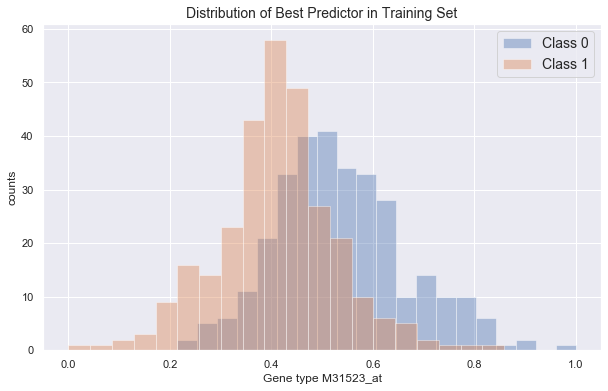

In [8]:
# best_predictor histogram based on training set

f, ax = plt.subplots(1,1, figsize=(10, 6));
sns.distplot(X_train_0[[best_predictor]], kde=False, bins=20, label='Class 0')
sns.distplot(X_train_1[[best_predictor]], kde=False, bins=20, label='Class 1')
ax.set_title('Distribution of Best Predictor in Training Set', fontsize=14)
ax.set_xlabel(f'Gene type {best_predictor}');
ax.set_ylabel('counts');
ax.legend(loc='best', fontsize=14);

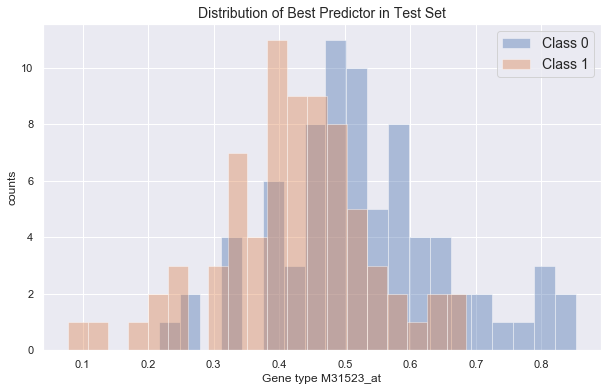

In [9]:
# histogram based on testing set  

# reindex y_test first
y_test_reindexed = y_test.reset_index()

f, ax = plt.subplots(1,1, figsize=(10, 6));
sns.distplot(X_test[best_predictor][y_test_reindexed['Cancer_type'] == 0.0], kde=False, bins=20, label='Class 0')
sns.distplot(X_test[best_predictor][y_test_reindexed['Cancer_type'] == 1.0], kde=False, bins=20, label='Class 1')
ax.set_title('Distribution of Best Predictor in Test Set', fontsize=14)
ax.set_xlabel(f'Gene type {best_predictor}');
ax.set_ylabel('counts');
ax.legend(loc='best', fontsize=14);

**1.4 Using your top gene from the previous part (call it  `best_predictor`), create a classification model by eye-balling a value for this gene that would discriminate the two classes the best. Justify your choice in 1-2 sentences. Report the accuracy of this hand-chosen model on the test set.**


*A value for this gene that would discriminate between the two classes for this gene would be around $0.42$. I believe that this value would work because, according to the test graph, that value discrepancy between the two classes is very high so it is easy to distinguish.*


<div class='exercise'><b> Question 2 [25 pts]: Linear and Logistic Regression  </b></div>


In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor that you identify as the best predictor above to explore these two methods.

**2.1** Fit a simple linear regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. The scores predicted by the regression model for a patient could be interpreted as an estimate of the probability that the patient has Cancer_type=1 (AML). Is there a problem with this interpretation?


Create a figure with following items displayed on the same plot (use training data):
 - the predicted quantitative response from the linear regression model as a function of the best gene predictor
 - the true binary response. 


**2.2** Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes' classifier.  Evaluate the classification accuracy of this classification model on both the training and test sets.


**2.3** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? 

Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000'). 


**2.4** 
Print and interpret the logistic regression coefficients: the 'slope' and intercept. 


Create 2 plots (one each for training and testing data) with 4 items displayed on each plot.
- the predicted quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 



### Solutions

**2.1** **Fit a simple linear regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. The scores predicted by the regression model for a patient could be interpreted as an estimate of the probability that the patient has Cancer_type=1 (AML).  Is there a problem with this interpretation?**



In [10]:
# Simple Linear regression - following section 5
model_linear = LinearRegression()

# Fit the model on training data
# Using double brackets so it has the right shape
model_linear.fit(X_train[[best_predictor]], y_train)

# Predict
y_pred_train_lin = model_linear.predict(X_train[[best_predictor]].values.reshape(-1,1))
y_pred_test_lin = model_linear.predict(X_test[[best_predictor]].values.reshape(-1,1))

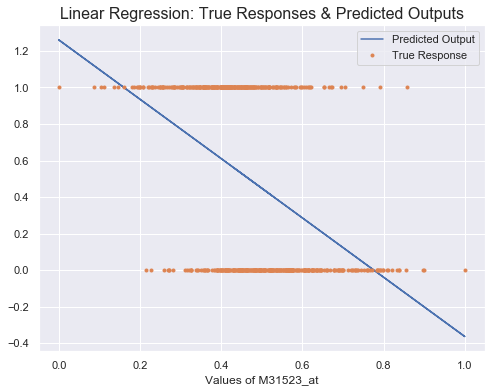

In [11]:
# plotting true values and predictions
f,ax = plt.subplots(1,1, figsize=(8,6))
# Plot Linear Predictions
ax.plot(X_train[[best_predictor]], y_pred_train_lin, label= 'Predicted Output')
ax.plot(X_train[[best_predictor]], y_train, '.', label= 'True Response')
ax.legend()
ax.set_title('Linear Regression: True Responses & Predicted Outputs', fontsize=16);
ax.set_xlabel(f'Values of {best_predictor}');

*The correct interpretation of the score is how accurately it predicts the correct class. In this case, our linear model correctly predicts the class of the best predictor about 65% of the time. It is better interpreted as an estimate of the probability that the model correctly predicted the patient's cancer type.* 


**2.2** **Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes' classifier.  Evaluate the classification accuracy of this classification model on both the training and test sets.**

In [12]:
# Classifying testing observations with np.round(y_test)
# y_pred_train_lin2 = np.round(model_linear.predict(X_train[[best_predictor]])).astype(int)
# y_pred_test_lin2 = np.round(model_linear.predict(X_test[[best_predictor]])).astype(int)

# Score
train_score_lin = accuracy_score(y_train, np.round(y_pred_train_lin))*100
test_score_lin = accuracy_score(y_test, np.round(y_pred_test_lin))*100

print("Training Set Accuracy:",str(train_score_lin)+'%')
print("Testing Set Accuracy:",str(test_score_lin)+'%')

Training Set Accuracy: 70.88186356073211%
Testing Set Accuracy: 68.87417218543047%



**2.3** **Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Are the classifications substantially different?  Explain why this is the case.**

**Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000').

In [13]:
# Simple Logistic Model - following section 5 again
model_logistic = LogisticRegression(C=100000, solver = "lbfgs", fit_intercept = True).fit(X_train, y_train)

# Predict
y_pred_train_log = model_logistic.predict(np.array(X_train[best_predictor]).reshape(-1,1))
y_pred_test_log = model_logistic.predict(np.array(X_test[best_predictor]).reshape(-1,1))

# Score
train_score_log = accuracy_score(y_train, y_pred_train_log)*100
test_score_log = accuracy_score(y_test, y_pred_test_log)*100

print("Training Set Accuracy:",str(train_score_log)+'%')
print("Testing Set Accuracy:",str(test_score_log)+'%')

Training Set Accuracy: 70.71547420965058%
Testing Set Accuracy: 70.86092715231787%


*I could not figure out how to properly predict this data with `predict_proba`. I kept getting the error that the classification metrics couldn't handle a mix binary and continuous output targets. My current output, however, shows a slight difference in testing accuracy which is to be expected given that the logistic model is better suited to predicted binary class output.*


**2.4 Print and interpret the logistic regression coefficients: the 'slope' and the intercept.**

**Create 2 plots (with training and test data) with 4 items displayed on each plot.**
- the predicted quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$.

**Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer.** 


In [14]:
# Logistic regression coefficients - from lecture 10 slides
print('beta_1 estimate is \n', model_logistic.coef_)
print('beta_0 estimate is \n', model_logistic.intercept_)

beta_1 estimate is 
 [[-8.75716206]]
beta_0 estimate is 
 [4.07730445]


The interpretation for $\beta_1$ is that any increase of the presence of the cancer, the gene's ability to predict it correctly would decrease by -8.75.

The interpretation for $\beta_0$ is that, no matter the gene, any increase of the presence of the cancer would make it this much harder to predict accurately.

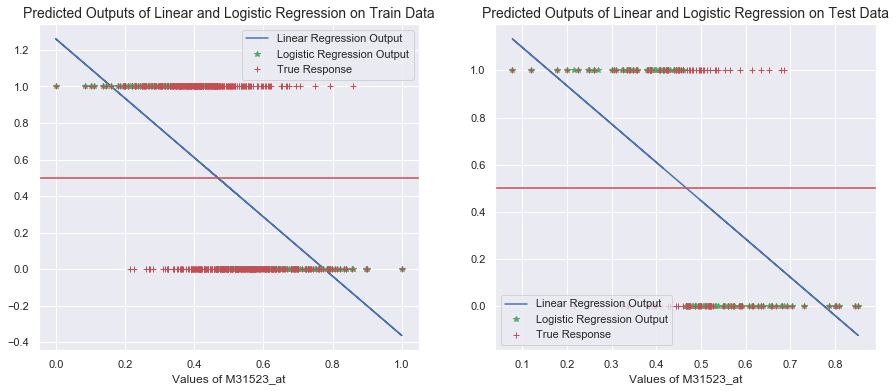

In [15]:
# Plotting
f, ax = plt.subplots(1,2, figsize = (15,6))

# TRAINING PLOT
# Plot Linear Regression results
ax[0].plot(X_train[[best_predictor]], y_pred_train_lin, label= 'Linear Regression Output')
# Plot Logistic Regression results
ax[0].plot(X_train[[best_predictor]], y_pred_train_log, 'g*', label= 'Logistic Regression Output')
# True Binary Values
ax[0].plot(X_train[[best_predictor]], y_train, 'r+', label= 'True Response')
# Plot y=0.5
ax[0].axhline(y=0.5, color='r', linestyle='-');
ax[0].legend()
ax[0].set_title('Predicted Outputs of Linear and Logistic Regression on Train Data', fontsize=14);
ax[0].set_xlabel(f'Values of {best_predictor}');

# TESTING PLOT
# Plot Linear Regression results
ax[1].plot(X_test[[best_predictor]], y_pred_test_lin, label= 'Linear Regression Output')
# Plot Logistic Regression results
ax[1].plot(X_test[[best_predictor]], y_pred_test_log, 'g*', label= 'Logistic Regression Output')
# True Binary Values
ax[1].plot(X_test[[best_predictor]], y_test, 'r+', label= 'True Response')
# Plot y=0.5
ax[1].axhline(y=0.5, color='r', linestyle='-');
ax[1].legend()
ax[1].set_title('Predicted Outputs of Linear and Logistic Regression on Test Data', fontsize=14);
ax[1].set_xlabel(f'Values of {best_predictor}');

*Yes, the logistic regression model seems to work better for binary clasification. It seems that Linear regression tends to predict some values into a class that doesn't exist (this is especally evident in the test set). Logistic regression is better suited to binary prediction because of its likelihood based approach.*

<div class='exercise'> <b> Question 3 [20pts]: Multiple Logistic Regression </b> </div>


**3.1** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  


**3.2** How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.

**Hint:** To answer this question, use *bootstrapping* with 100 bootstrap samples/iterations.  


**3.3** Comment on the classification accuracy of training and test set? Given the results above how would you assess the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole? 

**3.4** Now use regularization to improve predictions from the multiple logistic regression model.  Use LASSO-like regularization and cross-validation within the training set to tune the model.  Report the classification accuracy on both the training and test set.

**3.5** Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).

### Solutions

**3.1** **Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?**  


In [16]:
# following lab 6
# instantiate logistic regression model
lr = LogisticRegression(solver="lbfgs", max_iter=5000)
# fit the data on the training set
lr.fit(X_train, y_train)

# Predict
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# Score
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

Training Set Accuracy: 100.0%
Testing Set Accuracy: 81.45695364238411%


*The training prediction based on all the predictors performed much better on the training set which makes sense since the model was fitted on all the predictors. However, the performance hasn't changed for the testing set.* 


**3.2** **How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.**

**Hint:** **To answer this question, use *bootstrapping* with 1000 bootstrap samples/iterations.**  


In [17]:
from sklearn.utils import resample

# initialize paramaters
nsims = 100
# store all the indeces of X_train in a list
X_train_indexes = X_train.index.tolist()
# pre intialize a list to store all the arrays of coefficients
coef_arrays = []
# preinitialize a list to stores all the coefficient means
coef_means = []

# In the simulation:
# resample X_train and y_train (by index) with replacement
# Fit a logistic model to it
# append the array of coefficients to the coef_arrays list
for i in range(0, nsims):
    # reindex y_train
    y_train_reindexed_boot = y_train.reset_index()
    
    # resample X_train and y_train (by index) with replacement
    # get sample of indeces
    boot = resample(X_train_indexes, replace=True)  # GOT RID OF RANDOM STATE BUT IT DIDN'T FIX PROBLEM
    
    # create sample of X_train and y_train
    X_train_boot = X_train.loc[boot]
    y_train_boot = y_train_reindexed_boot['Cancer_type'].loc[boot]
    
    # Fit multiple logistic model to this
    lr_boot = LogisticRegression(C=100000, solver="lbfgs", fit_intercept = True, max_iter=500).fit(X_train_boot, y_train_boot)
    
    # get the coefficients
    coef_boot = lr_boot.coef_
    
    # append the arracy of coefficients to the list
    coef_arrays.append(coef_boot)

# get the mean (and standard deviation) of each array in coef_list
for i in range(0, len(coef_arrays)):
    coef_means.append(np.mean(coef_arrays[i]))

# get the means between 2.5% and 97.5%
conf_int = [np.percentile(coef_means, 2.5), np.percentile(coef_means, 97.5)]

In [18]:
# Printing out the confidence interval
print('The coeficients that are significantly different from 0 are within this confidence interval: ', conf_int)

The coeficients that are significantly different from 0 are within this confidence interval:  [-0.00026044672890069924, 0.003662829837175506]


**3.3 Open question: Comment on the classification accuracy of training and test set? Given the results above how would you assest the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole.**

*Given that the accuracy on the training set was a 100% and it improved on the test set, it seems that the classification accuracy is technically better. For that reason, I think it makes sense to believe that the model can be generalized. Other tests to better guard the sense of security include ...*

**3.4 Now use regularization to improve predictions from the multiple logistic regression model.  Use LASSO-like regularization and cross-validation within the training set to tune the model.  Report the classification accuracy on both the training and test set.**

In [19]:
# Using regularization and cross validation
# changed solver to "saga" based on what I saw in the documentation (for large dataset and l1 penalty)
model_log_cv = LogisticRegressionCV(Cs=100000, cv = 5, solver="saga", max_iter = 8, fit_intercept = True, penalty = 'l1')
model_log_cv.fit(X_train, y_train)  # fit on train data

# Predict?
y_train_pred_CV = model_log_cv.predict(X_train)
y_test_pred_CV = model_log_cv(X_test)

# Score
train_score_cv = accuracy_score(y_train, y_train_pred_CV)
test_score_cv = accuracy_score(y_test, y_test_pred_CV)

print("CV Training Set Accuracy:",str(train_score_cv)+'%')
print("CV Testing Set Accuracy:",str(test_score_cv)+'%')

KeyboardInterrupt: 

**3.5: Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).**

In [ ]:
# look for all the predictors among the best 10 that aren't 0 by lasso and talk about why

*I was not able to approach this properly since I could not get 3.4 to work. However, I would expect that at least one of the best predictors would be deemed insignificant by Lasso regularization. This may be because it was the among the best 10 predictors but may have not had a p-value below 0.05.* 


<div class='exercise'> <b> Question 4 [25pts]: Multi Class Log Regression </b> </div>

**4.1** Load the data from `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset? 

**4.2** Split the dataset into train and test, 80-20 split, random_state = 8. 

We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using the training dataset.  It should be easily discernable via labeling/marking in the plot which observations belong to which `cancer_type`.

**4.3** Fit the following two models using crossvalidation: 
- Logistic Regression Multiclass model with linear features. 
- Logistic Regression Multiclass model with Polynomial features, degree = 2.

**4.4** Plot the decision boundaries for each model and interpret the results. Hint: You may utilize the function `overlay_decision_boundary`. 

**4.5** Report and plot the CV scores for the two models and interpret. 


### Solutions

**4.1 Load the data from `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset?**

In [20]:
# Open zipfile first
z = zipfile.ZipFile("data/hw4_mc_enhance.csv.zip")
# load the right one into a dataframe
df2 = pd.read_csv(z.open('hw4_mc_enhance.csv'), index_col=0)

# Examining structure
print(df2.shape)
df2.describe()

(750, 7130)


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer_type
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,...,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,-1014.598658,-1048.357272,-823.358695,-315.636838,-1295.949886,-1625.120199,-826.955064,-1175.612555,-588.598064,-534.924646,...,812.768978,-747.263549,16.272227,-801.847334,1031.081628,-3.162310,-723.364564,-40.495922,-810.150889,1.000000
std,297.369331,233.933609,392.662256,215.534283,320.799277,419.687380,562.688520,288.546511,227.362605,489.552685,...,663.320928,176.481127,751.988770,157.068732,966.569338,495.241653,138.805059,882.681724,176.347552,0.817041
min,-2010.202020,-1772.451092,-1619.756151,-930.821077,-1984.530972,-2514.619404,-2766.759937,-1725.591441,-1255.146509,-1552.135008,...,-375.241836,-1484.465401,-853.838447,-1367.829068,-571.900054,-838.747726,-1162.232820,-1266.486530,-1298.638023,0.000000
25%,-1141.429466,-1218.887728,-1076.151552,-454.824979,-1548.108060,-1848.322368,-1203.978707,-1371.756006,-718.014815,-853.188715,...,322.566010,-847.468558,-335.783011,-924.099294,337.355440,-356.629007,-820.617263,-435.750013,-933.182073,0.000000
50%,-1033.862143,-1024.510062,-896.612263,-255.321214,-1257.060242,-1701.504007,-875.340089,-1138.486182,-586.848142,-554.578969,...,639.993676,-750.170322,-130.115409,-783.870080,777.827303,-180.519462,-733.242628,-261.276132,-816.239345,1.000000
75%,-837.607536,-885.604686,-560.246417,-196.687009,-1092.191607,-1259.153655,-508.663556,-978.433566,-416.287415,-173.861061,...,1355.814050,-654.438425,117.823076,-706.793736,1571.382500,209.283781,-609.175359,36.278669,-708.453545,2.000000
max,-385.768608,-477.363374,130.829434,257.521293,-304.800847,-850.745403,929.737460,-466.326738,196.149024,988.039921,...,2482.375600,-230.208352,5082.744968,-428.086002,4221.275650,1363.790953,-427.657222,5845.204223,-268.531949,2.000000


In [21]:
# Finding instances of each class
print(df2.cancer_type.value_counts(normalize=True))

2.0    0.333333
1.0    0.333333
0.0    0.333333
Name: cancer_type, dtype: float64


**4.2 Split the dataset into train and test, 80-20 split, random_state = 8.**

**We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using training dataset.  We should be able to discern from the plot which sample belongs to which `cancer_type`.** 

In [22]:
# splitting the dataset
X_train_multi, X_test_multi, y_train_multi, y_test_multi =train_test_split(df2.loc[:, df2.columns != 'cancer_type'], 
                                                         df2.cancer_type, test_size=0.2, 
                                                         random_state = 8, 
                                                         stratify = df2.cancer_type)

In [23]:
# Normalizing data - following Section 4

# store the columns first
columns2 = X_train_multi.columns.values.tolist()

# Normalize X_train
scaler = MinMaxScaler()
X_train_multi = scaler.fit_transform(X_train_multi)  # turns it into a numpy array
X_train_multi = pd.DataFrame(X_train_multi, columns = columns2)   # need to turn it back into a dataframe

# Normalize X_test
X_test_multi = scaler.transform(X_test_multi)  # turns it into a numpy array
X_test_multi = pd.DataFrame(X_test_multi, columns = columns2)   # need to turn it back into a dataframe

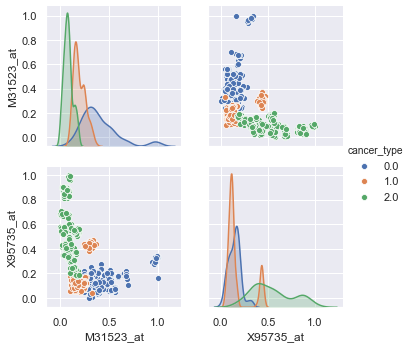

In [24]:
# using seaborn to plot the scattermatrix - following lab 5
# join X_train (only the relevant features) with y_train (re index it to make it clearer)
joined_train = X_train_multi.loc[:,['M31523_at', 'X95735_at']].join(y_train_multi.reset_index()) 
sns.pairplot(joined_train, hue = 'cancer_type', vars = ['M31523_at', 'X95735_at']);

**4.3  Fit the following two models using crossvalidation:**

**Logistic Regression Multiclass model with linear features.**

**Logistic Regression Multiclass model with Polynomial features, degree = 2.**


In [25]:
# Linear features
model_lin_multi = LogisticRegression()
model_lin_multi.fit(X_train_multi, y_train_multi)

C:\Users\kkv09\Anaconda3\envs\cs109a\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\kkv09\Anaconda3\envs\cs109a\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
# following section 5
# polynomial features, degree = 2, using pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_logreg_multi = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegression())

#Fit on train data
polynomial_logreg_multi.fit(X_train_multi, y_train_multi)

MemoryError: 

**4.4 Plot the decision boundary and interpret results. Hint: You may utilize the function `overlay_decision_boundary`** 


In [27]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier to use.
     - if `model` has a `.predict` method, like an sklearn classifier, we call `model.predict(X)`
     - otherwise, we simply call `model(X)`
    colors: list or dict of colors to use. Use color `colors[i]` for class i.
     - If colors is not provided, uses the current color cycle
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    xlim, ylim: range to plot on. (If the default, None, is passed, the limits will be taken from `ax`.)
    """
    # Create mesh.
    xmin, xmax = ax.get_xlim() if xlim is None else xlim
    ymin, ymax = ax.get_ylim() if ylim is None else ylim
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points.
    model = getattr(model, 'predict', model)
    y = model(X)
    #print("Do I predict" , y)
    
    
#     y[np.where(y=='aml')]=3
#     y[np.where(y=='allT')]=2
#     y[np.where(y=='allB')]=1
    
    
    
    y = y.astype(int) # This may be necessary for 32-bit Python.
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        # If colors not provided, use the current color cycle.
        # Shift the indices so that the lowest class actually predicted gets the first color.
        # ^ This is a bit magic, consider removing for next year.
        colors = (['white'] * np.min(y)) + sns.utils.get_color_cycle()

    if isinstance(colors, dict):
        missing_colors = [idx for idx in np.unique(y) if idx not in colors]
        assert len(missing_colors) == 0, f"Color not specified for predictions {missing_colors}."

        # Make a list of colors, filling in items from the dict.
        color_list = ['white'] * (np.max(y) + 1)
        for idx, val in colors.items():
            color_list[idx] = val
    else:
        assert len(colors) >= np.max(y) + 1, "Insufficient colors passed for all predictions."
        color_list = colors
    color_list = [sns.utils.desaturate(color, desaturate) for color in color_list]
    cmap = matplotlib.colors.ListedColormap(color_list)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
    if len(np.unique(y)) > 1:
        ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)
    else:
        print("Warning: only one class predicted, so not plotting contour lines.")

ValueError: X has 2 features per sample; expecting 7129

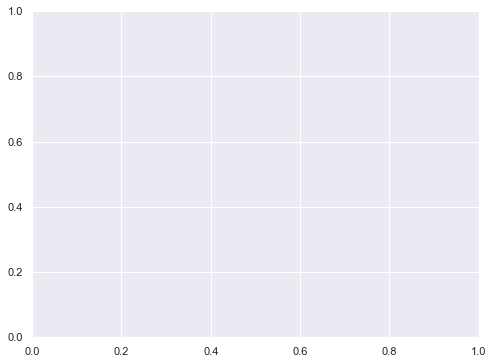

In [28]:
# Plotting decision boundary for linear
f, ax = plt.subplots(1, 1, figsize=(8, 6))

overlay_decision_boundary(ax, model = model_lin_multi)
    
ax.legend()
ax.set_title('')
ax.set_ylabel('')
ax.set_xlabel('')
    
plt.show()

ValueError: X shape does not match training shape

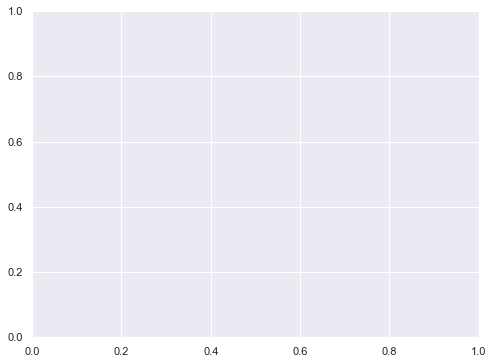

In [29]:
# Plotting decision boundary for polynomial
f, ax = plt.subplots(1, 1, figsize=(8, 6))

overlay_decision_boundary(ax, model = polynomial_logreg_multi)
    
ax.legend()
ax.set_title('')
ax.set_ylabel('')
ax.set_xlabel('')
    
plt.show()

*Interpretations of results of the plots*

**4.5 Report and plot the CV scores for the two models and interpret.**

*Did not get chance to properly do this since my code could not add polynomial features, but here is how I would approach it.*

In [30]:
# linear features score
linear_scores = cross_val_score(model_lin_multi, X_train_multi, y_train_multi, cv=5)

# polynomial features score
# polynomial_scores = cross_val_score(polynomial_logreg_multi, X_train_multi, y_train_multi, cv=5)

print("Linear Features CV Scores:",str(linear_scores))
# print("Polynomial CV Scores:",str(polynomial_scores)+'%')


C:\Users\kkv09\Anaconda3\envs\cs109a\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\kkv09\Anaconda3\envs\cs109a\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\kkv09\Anaconda3\envs\cs109a\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\kkv09\Anaconda3\envs\cs109a\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\kkv09\Anaconda3\envs\cs109a\lib\site-packages\skl

Linear Features CV Scores: [1. 1. 1. 1. 1.]


*Since my cross validation scores for the linear features models are all 1, this raises suspicion that the multiclass linear model was not the best. I imagine that the scores for my polynomial model would be different and more accurate since it is based on higher features.*

<div class='exercise'><b> Question 5: [10 pts] Including an 'abstain' option </b></div>

One of the reasons a hospital might be hesitant to use your cancer classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction: whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a specialist, which would incur additional cost.  How could one design a cancer classification model with an abstain option, such that the cost to the hospital is minimized?

*Hint:* Think of ways to build on top of the logistic regression model and have it abstain on patients who are difficult to classify.

**5.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from **Question 4**.  Note that this needs to be evaluated on the patients in the test set. 

**5.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.

<hr>
### Solutions

**5.1 More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 4.  Note that this needs to be evaluated on the patients in the test set.**
**
...
**

*your answer here* 


In [ ]:
# your code here


**5.2 Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.**

In [ ]:
# your code here
